In [1]:
%load_ext autoreload
%autoreload 2

In [298]:
import numpy as np
import matplotlib.pyplot as plt
from fastcore.all import *
from PIL import Image
import gc
from pathlib import Path 
import supervision as sv
import matplotlib as mpl
import cv2
sv.__version__



'0.6.0'

In [228]:
mpl.rcParams['image.cmap'] = 'gray'k

In [229]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True:w
                )
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

In [230]:

device = "cuda:0"
from transformers import pipeline
generator = pipeline(
                     "mask-generation",
                      model="facebook/sam-vit-huge",
                      device=device)

In [231]:
data_path = (Path.cwd()/'data/X')
images = data_path.ls()

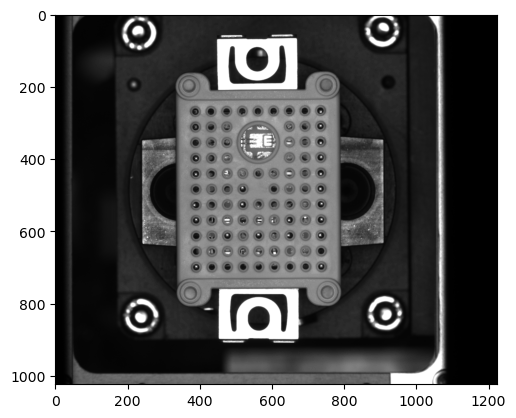

In [232]:
fn = images[1]
raw_img = Image.open(fn)
plt.imshow(raw_img)

In [233]:
outputs = generator(
                    raw_img,
                    points_per_batch=32,
                    iou_score=0.9
                    )

In [234]:
outputs.keys()

dict_keys(['masks', 'scores'])

In [244]:
masks = outputs["masks"]
#show_masks_on_image(raw_img, masks)

In [252]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(masks)))

CLASSES ={}
titles = [f'mask_{i}' for class_id in range(len(masks))]

In [287]:

def extract_circle_masks(binary_masks):
    # Apply morphological opening to remove small isolated regions and holes
    kernel = np.ones((3, 3), np.uint8)
    binary_masks = cv2.morphologyEx(binary_masks, cv2.MORPH_OPEN, kernel)

    # Find contours of connected components
    contours, _ = cv2.findContours(binary_masks, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    circle_masks = []
    for contour in contours:
        # Calculate minimum enclosing circle
        (x, y), radius = cv2.minEnclosingCircle(contour)

        # Check whether contour is close to a circle
        area = cv2.contourArea(contour)
        circle_area = np.pi * radius**2
        if abs(area/circle_area - 1) < 0.1:
            # Extract binary mask corresponding to circle contour
            mask = np.zeros_like(binary_masks)
            cv2.drawContours(mask, [contour], 0, 255, -1)
            circle_masks.append(mask)

    return circle_masks

In [294]:
np_mask = np.array(masks, dtype=np.uint8)
np_mask.shape

(127, 1024, 1224)

In [ ]:
masks

In [310]:
c_mask =[]
for i in np_mask:
    circle_masks = extract_circle_masks(i)
    if circle_masks:
        c_mask.append(circle_masks
                      )


In [331]:
cmbined_mask =  cv2.add(c_mask[0][0], c_mask[1][0])
for i in c_mask: 
    cmbined_mask = cv2.add(cmbined_mask, i[0])

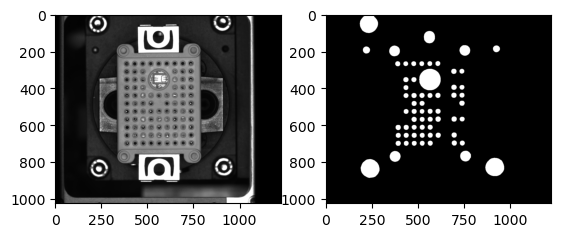

In [337]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(raw_img)
ax[1].imshow(cmbined_mask)
#plt.imshow(cmbined_mask)

In [324]:
resized_im = (np.array(c_mask[0]).astype(np.uint8)).resize(512, 512)

AttributeError: 'NoneType' object has no attribute 'shape'

In [307]:
circle_masks = extract_circle_masks(np.array(masks[0],dtype=np.uint8))
circle_masks

[]

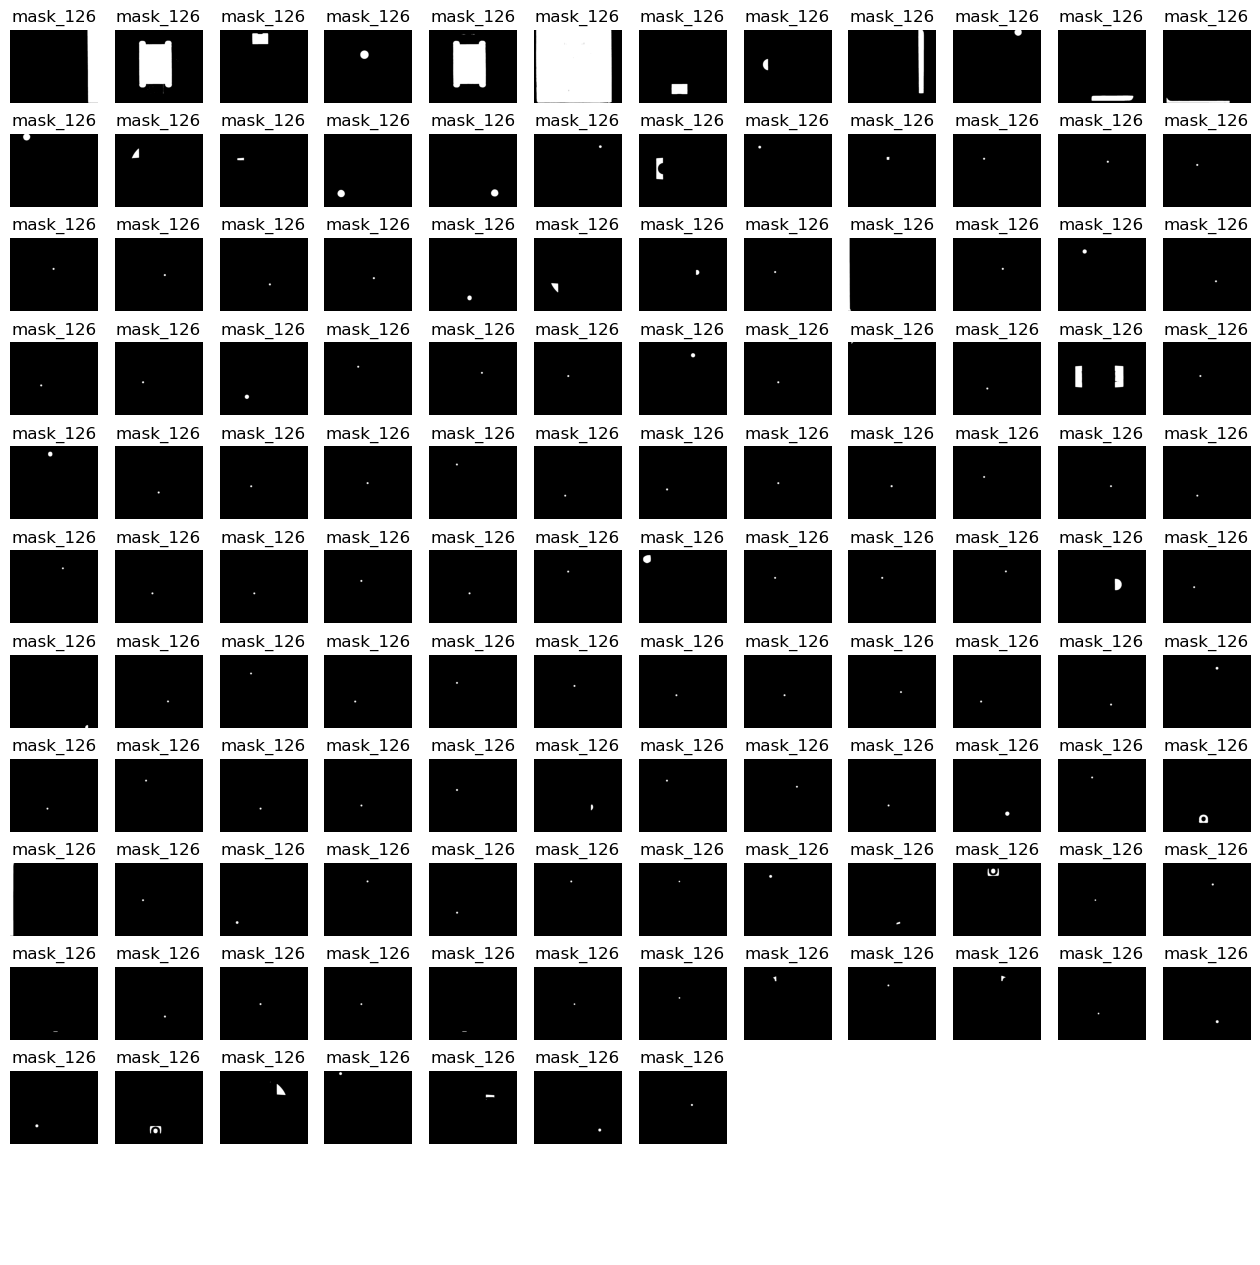

In [299]:


sv.plot_images_grid(
    images=masks,
    titles=titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16))

In [219]:
def get_largest_area(images: List[np.ndarray]) -> np.ndarray:
    largest_area =0
    def get_area_(mask: np.ndarray) -> int:
        return cv2.countNonZero(mask.astype(np.uint8))
    for i in images:
        area = get_area_(i)
        if area > largest_area:
            largest_area = area
            largest_mask = i
    return largest_mask
def get_smallest_area(images: List[np.ndarray]) -> np.ndarray:
    smallest_area =0
    def get_area_(mask: np.ndarray) -> int:
        return cv2.countNonZero(mask.astype(np.uint8))
    smallest_area = float('inf')
    for i in images:
        area = get_area_(i)
        if area > 0:
            area_ =  area
            if area_ < smallest_area:
                smallest_area = area_
                smallest_mask = i
            return smallest_mask
        print('Area is 0 ')
        return  None
    

In [220]:
largest_mask = get_largest_area(masks)

In [235]:
smallest_mask = get_smallest_area(masks):while

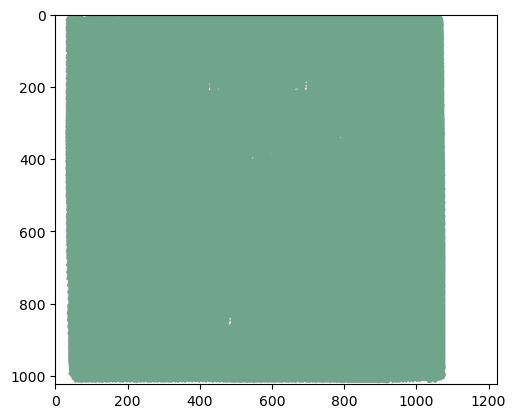

In [221]:
show_mask(largest_mask, plt.gca(), random_color=True)

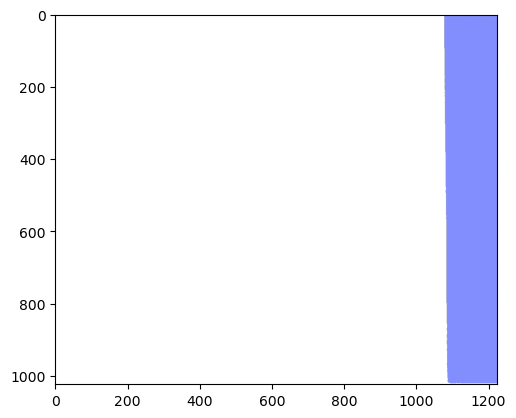

In [236]:
show_mask(smallest_mask, plt.gca(), random_color=True)

In [ ]:
CLASSES ={}

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 4 (CV_32S)


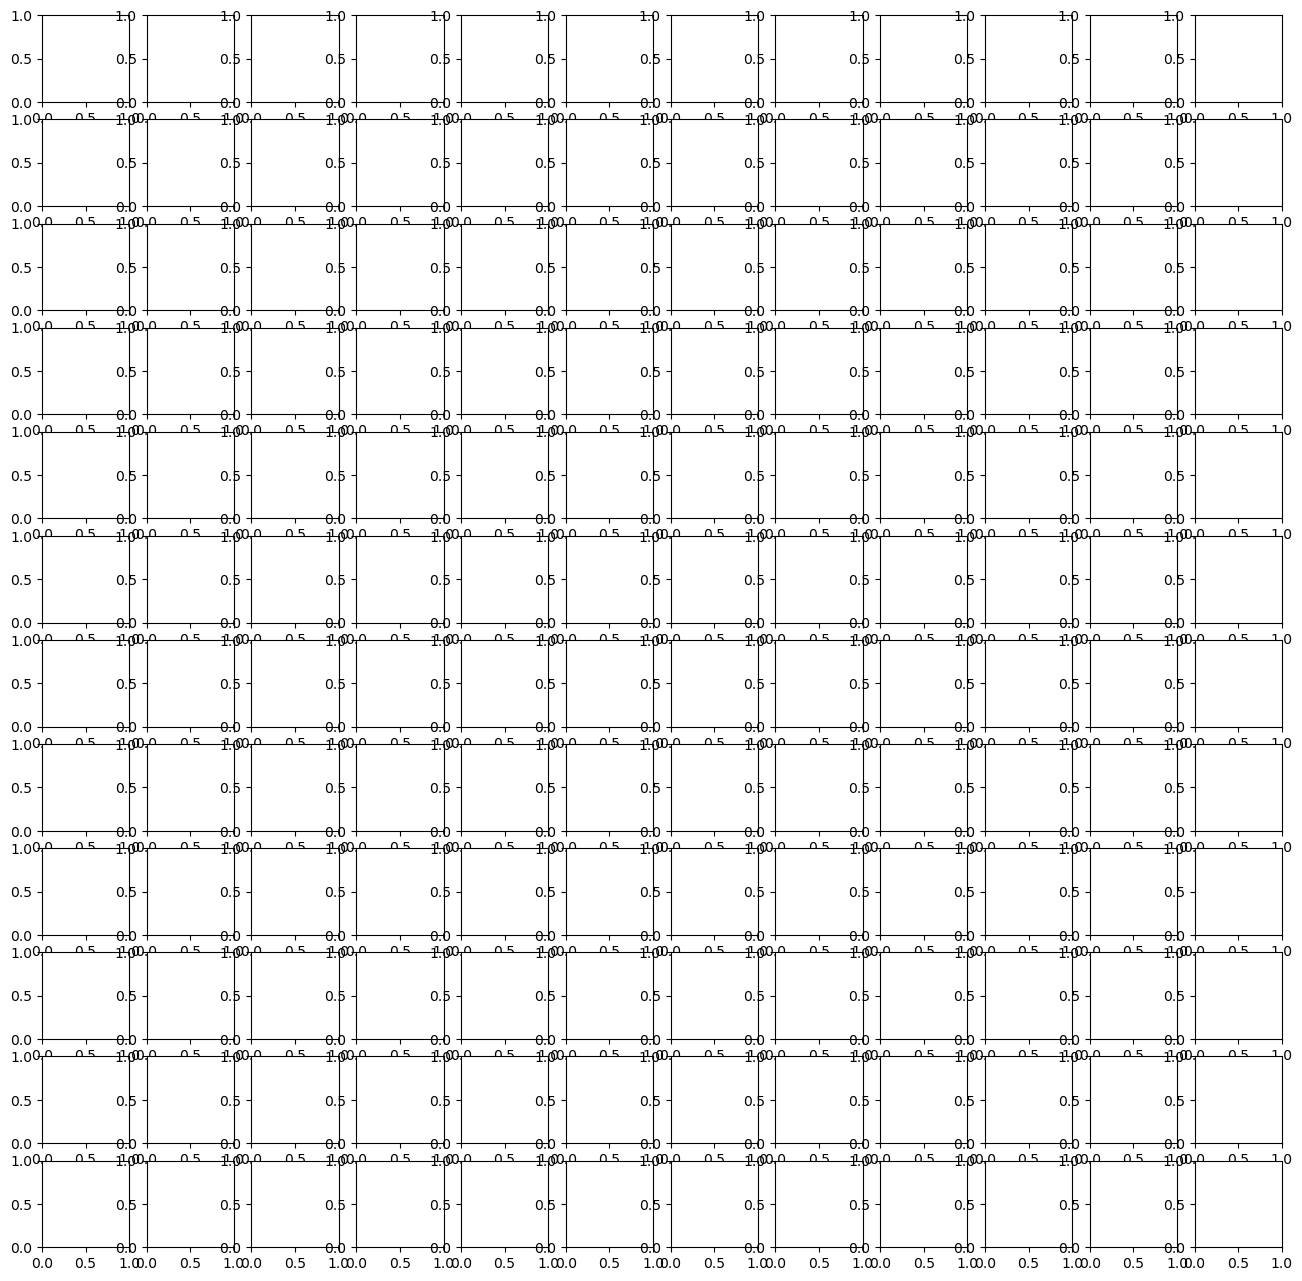

In [19]:
len(laragest_mask)

1024

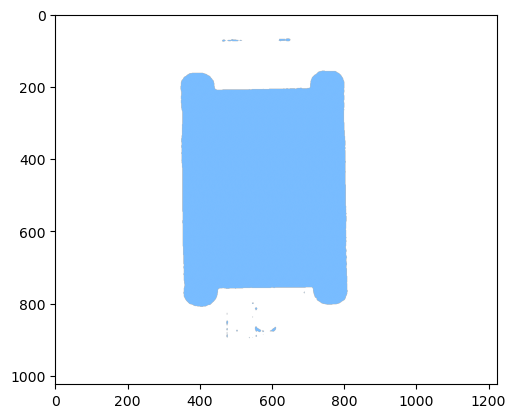

In [22]:
import math

grid_size_dimension = math.ceil(math.sqrt(len([largest_mask])))

titles = ['largest_mask'
]

show_mask(largest_mask, ax=plt.gca(), random_color=False)

In [12]:

grounding_dino_config_path = (
                               Path.cwd()/'GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py')

grounding_dino_checkpoint_path = (
                               Path.cwd()/'GroundingDINO/weights/groundingdino_swint_ogc.pth')


In [9]:
from groundingdino.util.inference import Model

In [14]:
print(grounding_dino_config_path.is_file())
print(grounding_dino_checkpoint_path.is_file())

True
True


In [15]:

grounding_dino_model = Model(
    model_config_path=grounding_dino_config_path,
    model_checkpoint_path=grounding_dino_checkpoint_path)

/home/hasan/mambaforge/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
CLASSES = ['rounded', 'round inside round']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

In [30]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

In [31]:
import cv2
raw_img = cv2.imread(str(fn))
detections = grounding_dino_model.predict_with_classes(
    image=raw_img,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

/home/hasan/mambaforge/lib/python3.10/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/hasan/mambaforge/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [32]:
detections

Detections(xyxy=array([], shape=(0, 4), dtype=float32), class_id=array([], dtype=float64), confidence=array([], dtype=float32), tracker_id=None)

In [33]:
# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}" 
    for _, _, confidence, class_id, _ 
    in detections]


In [37]:
detections

Detections(xyxy=array([], shape=(0, 4), dtype=float32), class_id=array([], dtype=float64), confidence=array([], dtype=float32), tracker_id=None)

In [34]:
annotated_frame = box_annotator.annotate(scene=raw_img.copy(), detections=detections, labels=labels)


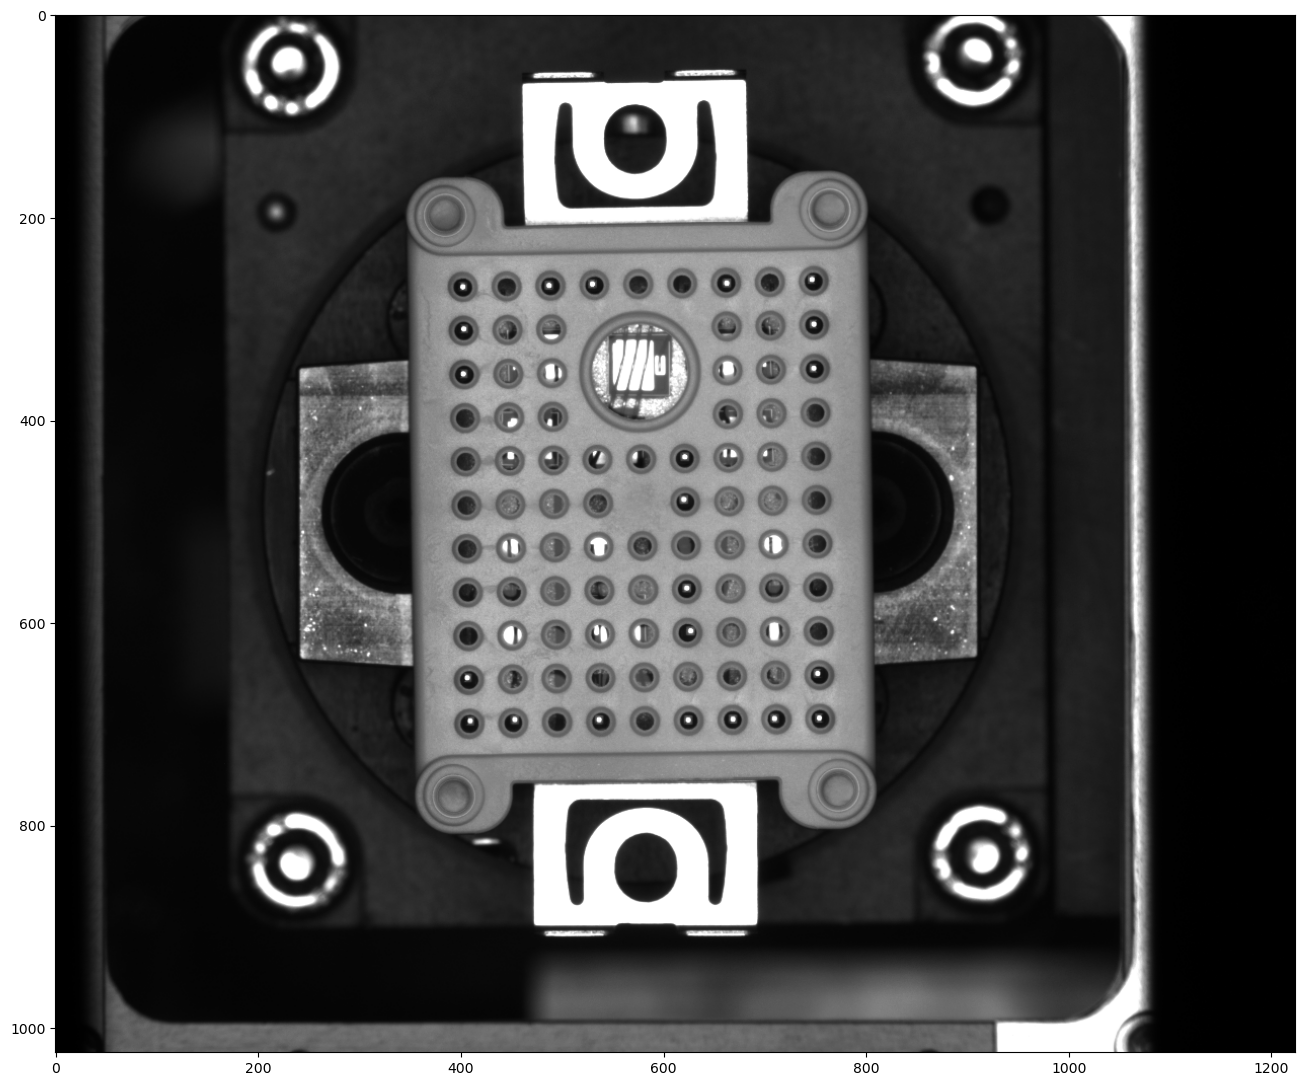

In [35]:

sv.plot_image(annotated_frame, (16, 16))

In [46]:
len(masks)

137

In [223]:
CLASSES = {}
for i  in range(len(masks)):
    mask_name = f'mask_{i}'
    CLASSES[i] = mask_name


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 4 (CV_32S)


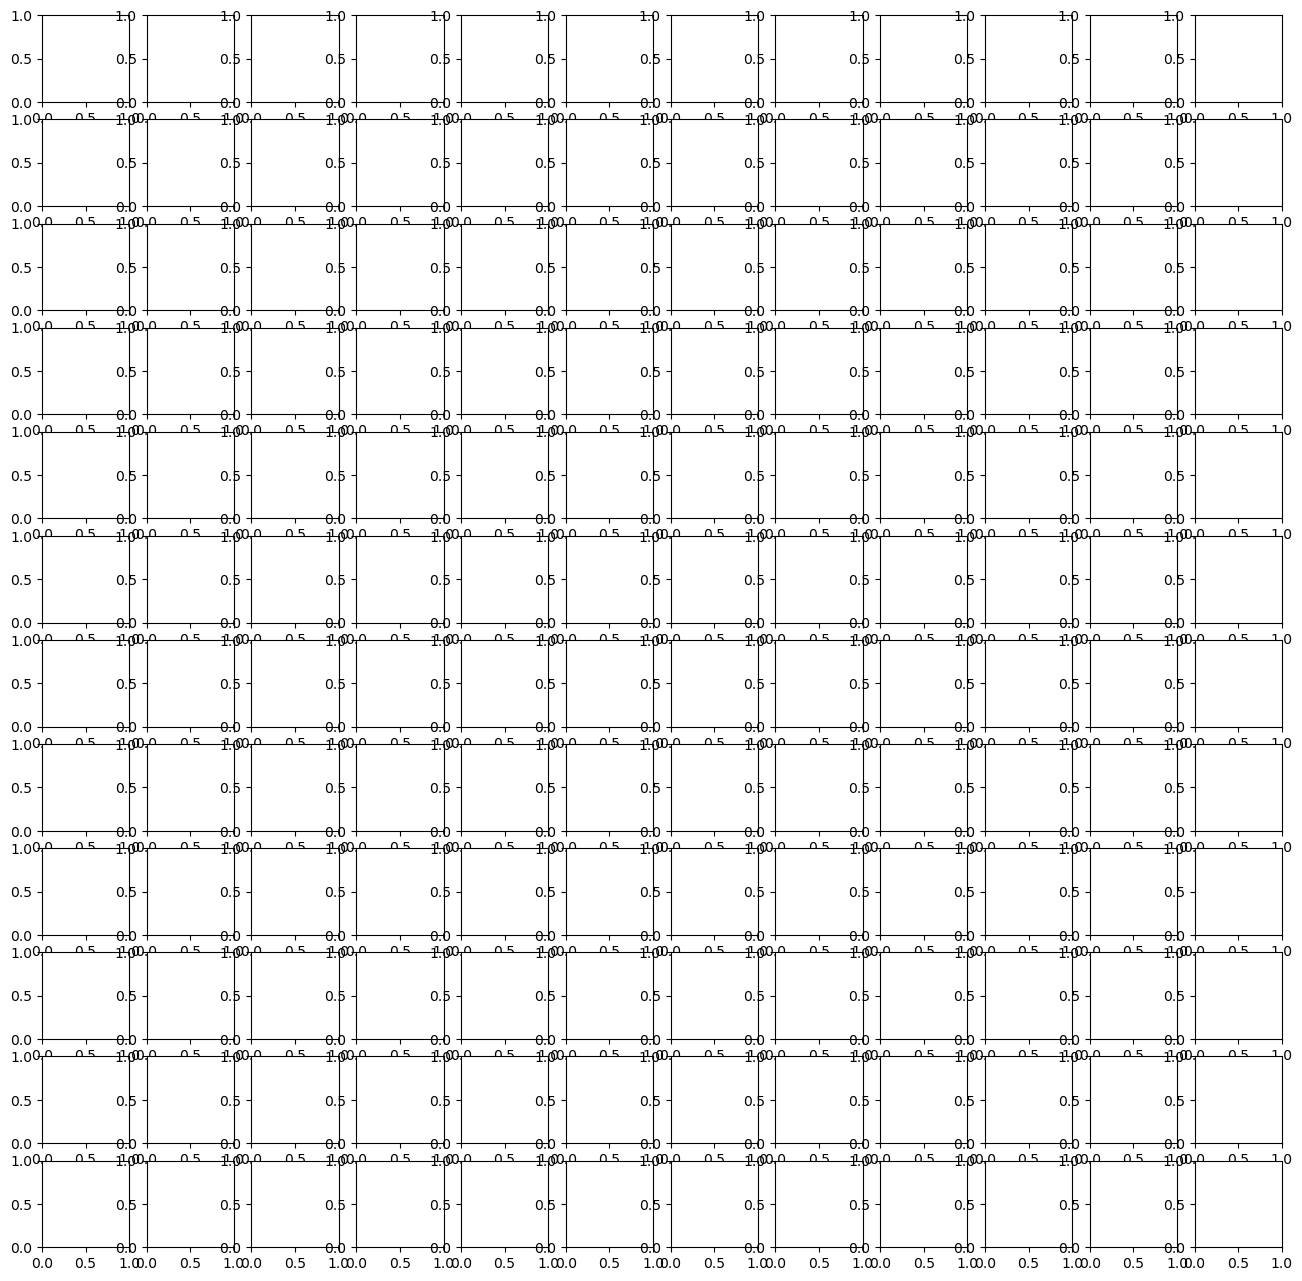

In [226]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(masks)))
masks = [i.astype(int) for i in masks]

titles = [
    CLASSES[class_id]
    for class_id
    in range(len(masks)) 
]

sv.plot_images_grid(
    images=masks,
    titles=titles,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16))


In [ ]:
# Get largest and smallest mask

In [ ]:
def get_largest_area(images: List[np.ndarray]) -> np.ndarray:
    def get_area_(mask: np.ndarray) -> int:
        return cv2.countNonZero(mask)
    for i in images:
        area = get_area_(i)
        if area > largest_area:
            largest_area = area
            largest_mask = i
    return largest_mask
def get_smallest_area(images: List[np.ndarray]) -> np.ndarray:
    def get_area_(mask: np.ndarray) -> int:
        return cv2.countNonZero(mask)
    for i in images:
        area = get_area_(i)
        if area > 0:
            if area < smallest_area:
                smallest_area = area
                smallest_mask = i
            return smallest_mask
        return 
    
    


In [58]:
removes_mask = [
                 132, 133, 135, 136, 
                 131, 130, 128, 127, 
                 126, 124, 109, 111,54, 
                 114, 107, 95, 92, 88, 85, 70,45,
                 55, 57, 45, 44, 24, 28, 13, 15, 23,
                 0, 2, 3, 4, 5, 6 , 8, 9, 10] 



In [59]:
masks_n = [CLASSES[i]for i in range(len(masks))if i not in  removes_mask]


In [60]:
masks_new = [masks[i]for i in range(len(masks)) if i not in removes_mask]

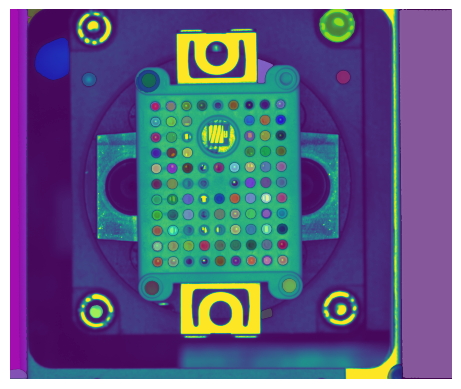

In [61]:
show_masks_on_image(raw_img, masks_new)

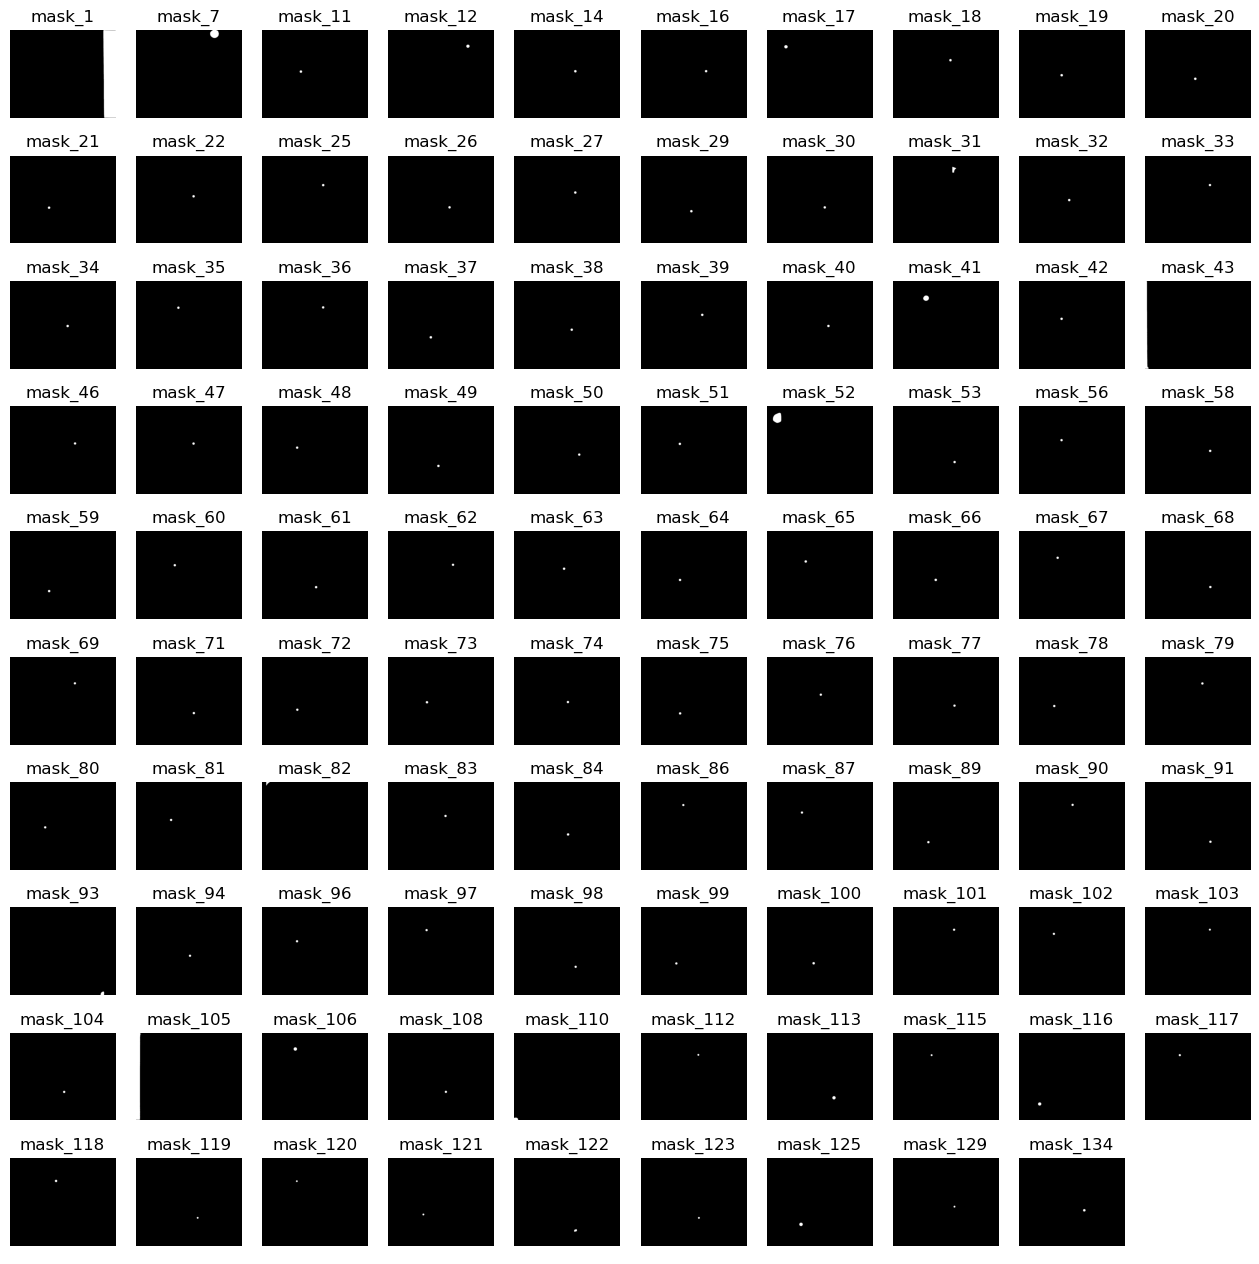

In [62]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(masks_new)))

titles = [
    CLASSES[class_id]
    for class_id
    in range(len(masks_n)) 
]

sv.plot_images_grid(
    images=masks_new,
    titles=masks_n,
    grid_size=(grid_size_dimension, grid_size_dimension),
    size=(16, 16))

# Zero Shot object detection


In [35]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection


In [36]:
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

In [152]:
#text_queries = [
                 #'circle', 
                 #'circle inside circle',
                  #'pin',
                  #'oval', 
                  #'round',
                  #'white',
                  #'white like circle',
                  #'white inside black',
                  #'shadow',
                  #'round',
                  #'round shape',
                  #'ball inside circle',
                  #'point inside circle',
                  #'ball inside round',
                  #'point inside round',
                  #'ball',
                #'hole',
                #'hole inside circle']
text_queries = ['small_ball', 'circles', 'shape', 'edge', 'round shape', 'round like shape']

In [153]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [154]:
device

device(type='cuda')

In [202]:
data_path = (Path.cwd()/'data/X')
images = data_path.ls()
fn = images[0]
raw_ = Image.open(str(fn))
raw_img_rgb = raw_.convert('RGB')

In [203]:
rsz = raw_img_rgb.resize((512, 512))

In [204]:
image = rsz
inputs = processor(text=text_queries, images=image,
                     return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([6, 16])
attention_mask: torch.Size([6, 16])
pixel_values: torch.Size([1, 3, 768, 768])


In [205]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

logits: shape of torch.Size([1, 576, 6])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 6, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([6, 16, 512])
pooler_output: shape of torch.Size([6, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [206]:
import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

In [207]:
# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(rsz, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0


In [208]:


# Threshold to eliminate low probability predictions
score_threshold = 0.0025

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

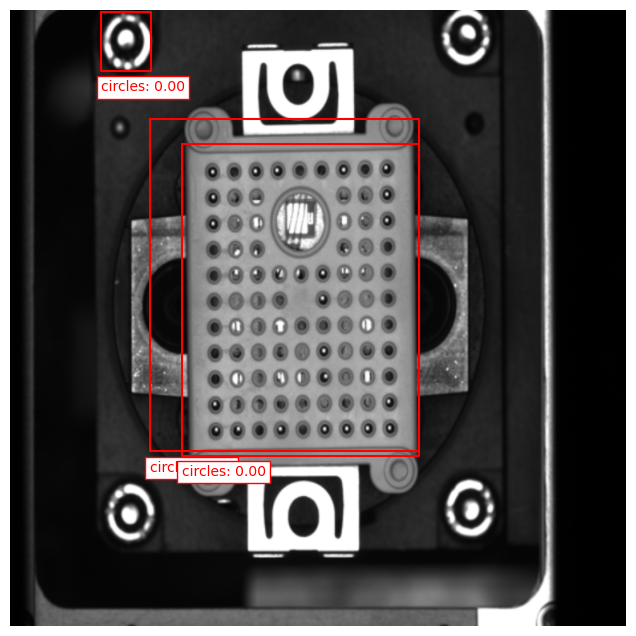

In [209]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
    
plot_predictions(input_image, text_queries, scores, boxes, labels)

In [210]:
text_queries

['small_ball', 'circles', 'shape', 'edge', 'round shape', 'round like shape']

In [22]:
np.max(scores)

0.011924327

In [104]:
text_queries

['circle', 'circle inside circle', 'pin', 'hole', 'chip', 'chip pin']

In [28]:
len(boxes)

576

In [ ]:
i